# Comparación antes vs después de la imputación

En este capítulo se comparan los datos originales (con valores faltantes) frente a los datos imputados.  
La meta es verificar cómo las técnicas de imputación afectan la distribución y consistencia de las variables.

**Puntos clave:**
- Comparar histogramas y estadísticos antes y después de imputar.
- Verificar si las imputaciones mantienen la coherencia de los datos.
- Identificar posibles sesgos introducidos por las técnicas.

Este análisis es un puente entre la imputación y la evaluación estadística formal.





In [11]:
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Cargar base original
csv_path = Path.cwd().parent / "base_imputacion_mixta_1000.csv"
if not csv_path.exists():
    raise FileNotFoundError("No se encontró base_imputacion_mixta_1000.csv")
df = pd.read_csv(csv_path)

# Fechas -> ordinal (para poder comparar e imputar como numéricas si aplica)
date_cols = []
for c in df.columns:
    if df[c].dtype == "object":
        parsed = pd.to_datetime(df[c], errors="coerce")
        if parsed.notna().mean() > 0.8:
            df[c] = parsed
            date_cols.append(c)
for c in date_cols:
    df[c] = df[c].map(lambda x: x.toordinal() if pd.notna(x) else np.nan)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols), "| Fechas convertidas:", date_cols)

# Usar imputaciones ya generadas en evaluacion.ipynb si existen; si no, se crean aquí
try:
    imputados = imputados_dict
    print("Usando imputaciones existentes:", list(imputados.keys()))
except NameError:
    from sklearn.experimental import enable_iterative_imputer  # noqa
    from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline

    pipe_mice = Pipeline([
        ("ct", ColumnTransformer([
            ("num", IterativeImputer(random_state=42, max_iter=10, sample_posterior=True), num_cols),
            ("cat", SimpleImputer(strategy="most_frequent"), cat_cols),
        ]))
    ])
    pipe_knn = Pipeline([
        ("ct", ColumnTransformer([
            ("num", KNNImputer(n_neighbors=5, weights="distance"), num_cols),
            ("cat", SimpleImputer(strategy="most_frequent"), cat_cols),
        ]))
    ])
    pipe_simple = Pipeline([
        ("ct", ColumnTransformer([
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", SimpleImputer(strategy="most_frequent"), cat_cols),
        ]))
    ])

    imputados = {}
    for nombre, pipe in {"MICE": pipe_mice, "KNN": pipe_knn, "Simple": pipe_simple}.items():
        X_imp = pipe.fit_transform(df)
        imputados[nombre] = pd.DataFrame(X_imp, columns=num_cols + cat_cols)
        print("Imputado:", nombre, imputados[nombre].shape)

tecnicas = list(imputados.keys())

Numéricas: 7 | Categóricas: 5 | Fechas convertidas: ['fecha']
Imputado: MICE (1000, 12)
Imputado: KNN (1000, 12)
Imputado: Simple (1000, 12)


In [12]:
def _props_cat(s):
    s = s.astype(str).fillna("NaN")
    return s.value_counts(normalize=True, dropna=False).sort_index()

def before_after_numeric(var, tecnica, bins=30):
    """Comparación 'Antes vs Después' para una variable numérica."""
    if var not in num_cols: 
        raise ValueError(f"'{var}' no es numérica.")
    df_imp = imputados[tecnica]

    x0 = df[var].dropna()
    x1 = df_imp[var].dropna()

    fig = plt.figure(figsize=(10,4))
    gs = fig.add_gridspec(1, 2, wspace=0.25)

    # Histograma
    ax1 = fig.add_subplot(gs[0,0])
    ax1.hist(x0, bins=bins, alpha=0.5, density=True, label="Antes (original)")
    ax1.hist(x1, bins=bins, alpha=0.5, density=True, label=f"Después ({tecnica})")
    ax1.set_title(f"Histograma: {var}")
    ax1.legend()

    # Boxplot lado a lado
    ax2 = fig.add_subplot(gs[0,1])
    ax2.boxplot([x0, x1], labels=["Antes", "Después"])
    ax2.set_title(f"Boxplot: {var}")
    plt.show()

    # Métricas básicas y KS
    ks = ks_2samp(x0, x1)
    tabla = pd.DataFrame({
        "Media":   [x0.mean(), x1.mean()],
        "Desv":    [x0.std(ddof=1), x1.std(ddof=1)],
        "Mín":     [x0.min(), x1.min()],
        "Máx":     [x0.max(), x1.max()]
    }, index=["Antes", "Después"])
    print(f"KS p-value (Antes vs Después): {ks.pvalue:.4f}")
    return tabla.round(4)

def before_after_categorical(var, tecnica, top=12):
    """Comparación 'Antes vs Después' para una variable categórica."""
    if var not in cat_cols: 
        raise ValueError(f"'{var}' no es categórica.")
    df_imp = imputados[tecnica]

    p0 = _props_cat(df[var])
    p1 = _props_cat(df_imp[var])

    # Barras de proporciones (top categorías)
    fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
    (p0*100).sort_values(ascending=False).head(top).plot(kind="bar", ax=ax[0], color="tab:blue")
    ax[0].set_title(f"{var} — Antes")
    ax[0].set_ylabel("%")

    (p1*100).sort_values(ascending=False).head(top).plot(kind="bar", ax=ax[1], color="tab:orange")
    ax[1].set_title(f"{var} — Después ({tecnica})")
    plt.tight_layout(); plt.show()

    # Tabla de conteos y proporciones + TVD
    idx = p0.index.union(p1.index)
    p0, p1 = p0.reindex(idx, fill_value=0), p1.reindex(idx, fill_value=0)
    tvd = 0.5 * np.abs(p0 - p1).sum()

    tabla = pd.DataFrame({
        "Antes_prop": (p0*100).round(2),
        "Después_prop": (p1*100).round(2),
        "Δ(p.p.)": ((p1 - p0)*100).round(2)
    }).sort_values("Antes_prop", ascending=False)
    print(f"TVD (Antes vs Después) = {tvd:.3f}  (0=idéntico, 1=muy distinto)")
    return tabla.head(top)

In [13]:
def comparar_todas_tecnicas(var):
    """Muestra 'Antes vs Después' para cada técnica en la variable dada."""
    if var in num_cols:
        for tec in tecnicas:
            print(f"\n=== {var} | {tec} ===")
            display(before_after_numeric(var, tec))
    elif var in cat_cols:
        for tec in tecnicas:
            print(f"\n=== {var} | {tec} ===")
            display(before_after_categorical(var, tec))
    else:
        raise ValueError("La variable no está en el dataset.")

# Ejemplo:
# comparar_todas_tecnicas("ingresos")     # numérica
# comparar_todas_tecnicas("estado_civil") # categórica

[Numérica] fecha — Técnica: KNN


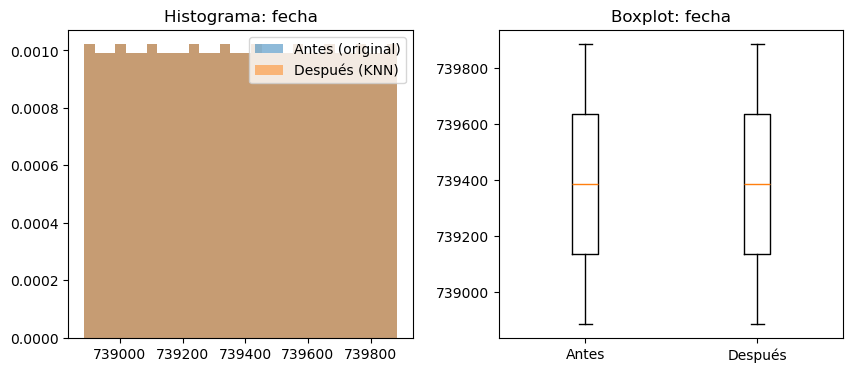

KS p-value (Antes vs Después): 1.0000


,Media,Desv,Mín,Máx
Antes,739385.5,288.8194,738886.0,739885.0
Después,739385.5,288.8194,738886.0,739885.0


[Categórica] sexo — Técnica: KNN


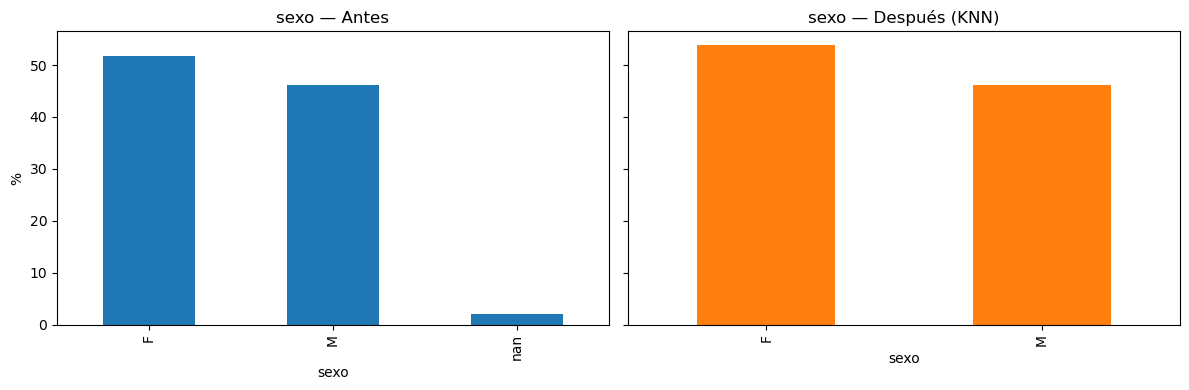

TVD (Antes vs Después) = 0.020  (0=idéntico, 1=muy distinto)


,Antes_prop,Después_prop,Δ(p.p.)
sexo,,,
F,51.8,53.8,2.0
M,46.2,46.2,0.0
nan,2.0,0.0,-2.0


In [14]:
# Elige una técnica y variables de ejemplo:
tec = "KNN"          # "MICE" | "KNN" | "Simple"
ej_num = num_cols[0] if num_cols else None
ej_cat = cat_cols[0] if cat_cols else None

if ej_num:
    print(f"[Numérica] {ej_num} — Técnica: {tec}")
    display(before_after_numeric(ej_num, tec))

if ej_cat:
    print(f"[Categórica] {ej_cat} — Técnica: {tec}")
    display(before_after_categorical(ej_cat, tec))

### Evaluación de la imputación con KNN

1. **Variable numérica: `fecha`**
   - El histograma y boxplot muestran que la distribución **antes y después de KNN es idéntica**.  
   - El test KS (p-value = 1.0) confirma que no hay diferencia estadísticamente significativa.  
    KNN preservó perfectamente la variable `fecha`.

2. **Variable categórica: `sexo`**
   - Antes de imputar había un pequeño porcentaje de valores faltantes (~2%).  
   - Después de KNN, esos `NaN` desaparecen y la distribución se ajusta ligeramente:  
     - Mujeres (F): de 51.8% a 53.8% (+2 p.p.).  
     - Hombres (M): se mantiene en 46.2%.  
   - El **TVD = 0.020** indica una variación muy baja respecto a la distribución original.  

3. **Interpretación general**
   - El KNN logró imputar los faltantes sin alterar de manera relevante la distribución de las variables.  
   - En categóricas, la técnica tiende a **favorecer la categoría mayoritaria** (aumenta un poco la proporción de mujeres).  
   - En numéricas, cuando los datos tienen estructura clara (como `fecha`), KNN mantiene la consistencia sin introducir sesgos.

 **Conclusión:**  
La imputación con KNN se comporta de forma **conservadora y estable**, preservando bien las distribuciones. Sin embargo, conviene vigilar variables categóricas desbalanceadas, ya que los faltantes suelen asignarse a la clase dominante.
